##**TUGAS 1: Observasi Berbagai Arsitektur CNN dalam Klasifikasi Objek**

Nama : Dody Adi Sancoko

NIM  : 1301223071



##**1. Import Dataset**

Dataset yang digunakan dalam eksperimen ini adalah Vegetable Image Dataset dari Kaggle, yang berisi 15.000 gambar yang telah terbagi secara seimbang ke dalam 15 kelas sayuran berbeda. Dataset ini memenuhi kriteria tugas karena memiliki lebih dari 10 kelas dan jumlah total citra melebihi 1000. Dataset dibagi ke dalam tiga bagian: train, validation, dan test.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/vegetable-image-dataset


## **2. Dataset Exploration**

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
base_path = '/kaggle/input/vegetable-image-dataset/Vegetable Images'

train_dir = os.path.join(base_path, 'train')
val_dir = os.path.join(base_path, 'validation')
test_dir = os.path.join(base_path, 'test')

### 2.1 Number of Classes

In [ ]:
# Ambil nama-nama kelas dari train folder
classes = sorted(os.listdir(train_dir))
num_classes = len(classes)

print(f"Jumlah kelas: {num_classes}")
print("Daftar kelas:")
for cls in classes:
    print(f"- {cls}")

Jumlah kelas: 15
Daftar kelas:
- Bean
- Bitter_Gourd
- Bottle_Gourd
- Brinjal
- Broccoli
- Cabbage
- Capsicum
- Carrot
- Cauliflower
- Cucumber
- Papaya
- Potato
- Pumpkin
- Radish
- Tomato


### 2.2 Number of Data

In [ ]:
# Hitung jumlah gambar per kelas
train_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}
val_counts = {cls: len(os.listdir(os.path.join(val_dir, cls))) for cls in classes}
test_counts = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in classes}

# Total data
total_train = sum(train_counts.values())
total_val = sum(val_counts.values())
total_test = sum(test_counts.values())

print(f"\nJumlah data:")
print(f"- Train     : {total_train}")
print(f"- Validation: {total_val}")
print(f"- Test      : {total_test}")


Jumlah data:
- Train     : 15000
- Validation: 3000
- Test      : 3000


In [ ]:
# Rincian jumlah gambar per kelas di train
print("\nJumlah gambar per kelas (data train):")
for cls, count in train_counts.items():
    print(f"{cls}: {count}")


Jumlah gambar per kelas (data train):
Bean: 1000
Bitter_Gourd: 1000
Bottle_Gourd: 1000
Brinjal: 1000
Broccoli: 1000
Cabbage: 1000
Capsicum: 1000
Carrot: 1000
Cauliflower: 1000
Cucumber: 1000
Papaya: 1000
Potato: 1000
Pumpkin: 1000
Radish: 1000
Tomato: 1000


### 2.3 Sample Image

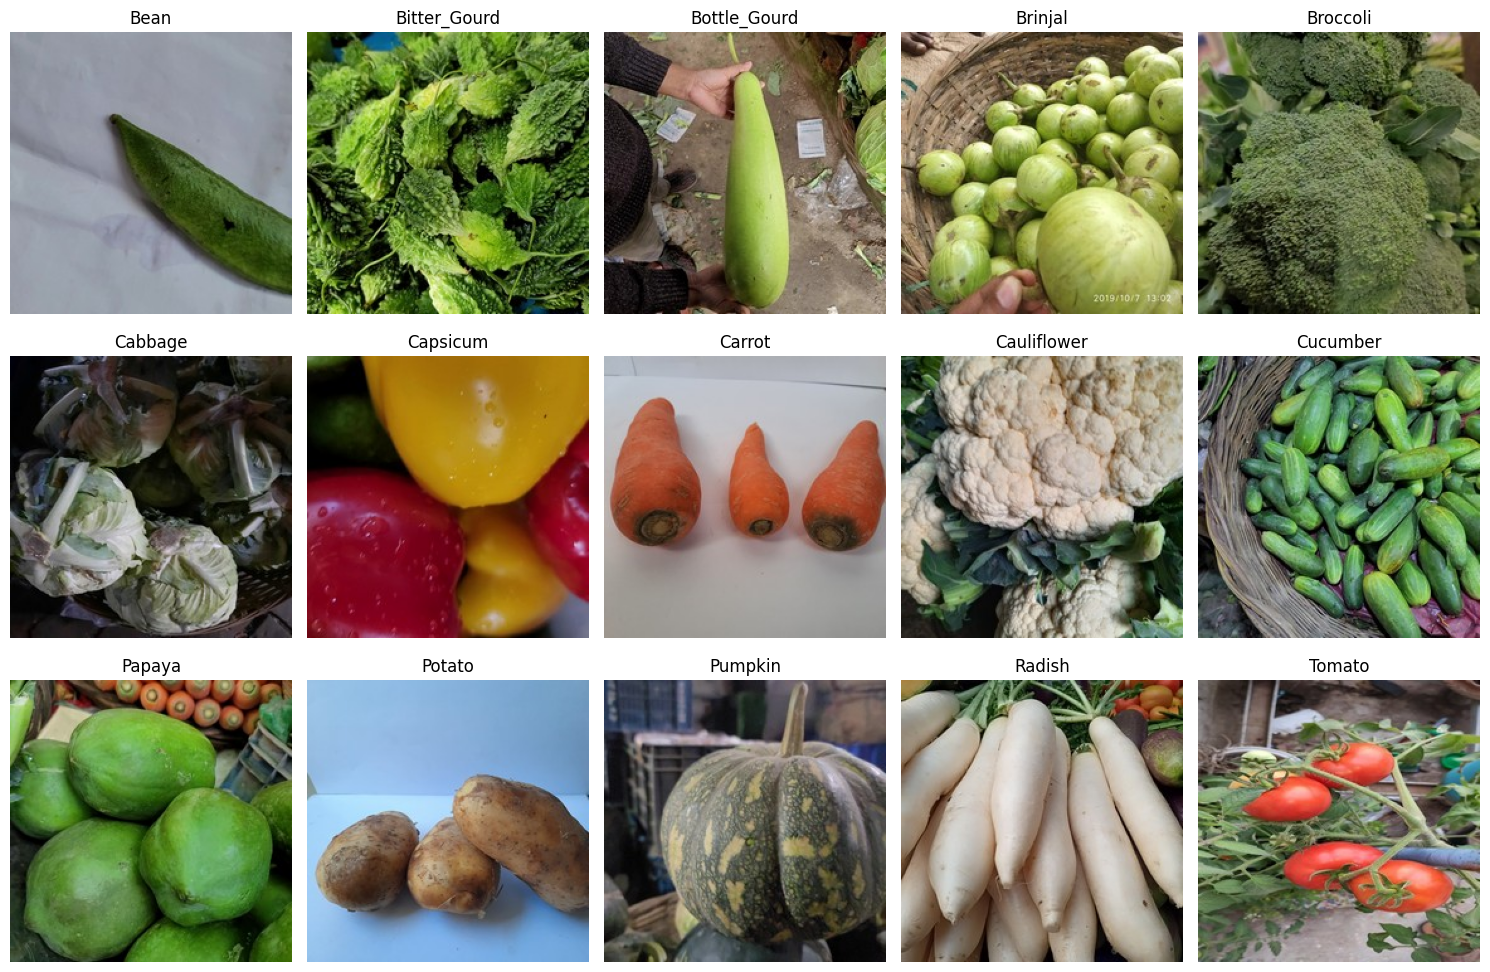

In [ ]:
# Visualisasi 1 contoh gambar per kelas + ambil dimensinya
image_dimensions = []

plt.figure(figsize=(15, 10))
for i, class_name in enumerate(classes):
    class_dir = os.path.join(train_dir, class_name)
    images = os.listdir(class_dir)

    # Baca gambar pertama
    image_path = os.path.join(class_dir, images[0])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Simpan dimensi gambar
    height, width, channels = image.shape
    image_dimensions.append((height, width, channels))

    # Tampilkan gambar
    plt.subplot(3, 5, i+1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


##**3. Preprocessing**

### 3.1 Generator for VGG16 & MobileNet

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


### 3.2 Generator for ResNet50

In [5]:
from tensorflow.keras.applications.resnet50 import preprocess_input

resnet_train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

resnet_val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

resnet_train_generator = resnet_train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

resnet_val_generator = resnet_val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

resnet_test_generator = resnet_val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


##**4. Model Implementation**

In [6]:
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D, Dense, Dropout

###**4.1 VGG16**

In [17]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg_base.layers:
    layer.trainable = False
x = Flatten()(vgg_base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
vgg_output = Dense(train_generator.num_classes, activation='softmax')(x)
vgg_model = Model(inputs=vgg_base.input, outputs=vgg_output)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


###**4.2 ResNet50**

In [7]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_base.trainable = False

for layer in resnet_base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(resnet_base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
resnet_output = Dense(resnet_train_generator.num_classes, activation='softmax')(x)

resnet_model = Model(inputs=resnet_base.input, outputs=resnet_output)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


###**4.3 MobileNetV2**

In [21]:
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in mobilenet_base.layers:
    layer.trainable = False
x = Flatten()(mobilenet_base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
mobilenet_output = Dense(train_generator.num_classes, activation='softmax')(x)
mobilenet_model = Model(inputs=mobilenet_base.input, outputs=mobilenet_output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


##**5. Training and Evaluation**

In [8]:
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [16]:
def evaluate_model(model, test_generator):
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    report = classification_report(y_true, y_pred, output_dict=True, target_names=test_generator.class_indices.keys())
    matrix = confusion_matrix(y_true, y_pred)
    return report, matrix

In [10]:
# Callbacks
callbacks_vgg = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_vgg_model.keras', monitor='val_loss', save_best_only=True)
]

callbacks_resnet = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
]

callbacks_mobilenet = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_mobilenet_model.keras', monitor='val_loss', save_best_only=True)
]

###**5.1 VGG16**

In [19]:
vgg_model.compile(optimizer=Adam(0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

vgg_start = time.time()

vgg_history = vgg_model.fit(train_generator,
                            validation_data=val_generator,
                            callbacks=callbacks_vgg,
                            epochs=15)

vgg_end = time.time()

vgg_report, vgg_conf_matrix = evaluate_model(vgg_model, test_generator)

vgg_train_time = vgg_end - vgg_start

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 239s 503ms/step - accuracy: 0.9022 - loss: 0.3257 - val_accuracy: 0.9813 - val_loss: 0.0700
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 224s 478ms/step - accuracy: 0.9532 - loss: 0.1630 - val_accuracy: 0.9860 - val_loss: 0.0559
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 256s 465ms/step - accuracy: 0.9703 - loss: 0.1053 - val_accuracy: 0.9893 - val_loss: 0.0421
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 219s 467ms/step - accuracy: 0.9771 - loss: 0.0832 - val_accuracy: 0.9917 - val_loss: 0.0313
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 220s 469ms/step - accuracy: 0.9820 - loss: 0.0673 - val_accuracy: 0.9937 - val_loss: 0.0237
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 273s 493ms/step - accuracy: 0.9842 - loss: 0.0549 - val_accuracy: 0.9930 - val_loss: 0.0229
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 223s 475ms/step - accuracy: 0.9838 - loss: 0.0510 - val_accuracy: 0.9947 - val_loss: 0.0198
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 263s 477ms/step - accuracy: 0.9859 -

###**5.2 ResNet50**

In [11]:
resnet_model.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

resnet_start = time.time()

resnet_history = resnet_model.fit(resnet_train_generator,
                                  validation_data=resnet_val_generator,
                                  callbacks=callbacks_resnet,
                                  epochs=30)

resnet_end = time.time()
resnet_train_time = resnet_end - resnet_start

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 263s 525ms/step - accuracy: 0.7300 - loss: 0.9544 - val_accuracy: 0.9973 - val_loss: 0.0316 - learning_rate: 1.0000e-04
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 198s 422ms/step - accuracy: 0.9868 - loss: 0.0684 - val_accuracy: 0.9977 - val_loss: 0.0126 - learning_rate: 1.0000e-04
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 197s 420ms/step - accuracy: 0.9908 - loss: 0.0376 - val_accuracy: 0.9987 - val_loss: 0.0087 - learning_rate: 1.0000e-04
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 203s 423ms/step - accuracy: 0.9952 - loss: 0.0226 - val_accuracy: 0.9983 - val_loss: 0.0052 - learning_rate: 1.0000e-04
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 195s 415ms/step - accuracy: 0.9966 - loss: 0.0157 - val_accuracy: 0.9983 - val_loss: 0.0049 - learning_rate: 1.0000e-04
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 196s 418ms/step - accuracy: 0.9958 - loss: 0.0144 - val_accuracy: 0.9987 - val_loss: 0.0041 - learning_rate: 1.0000e-04
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 

In [31]:
resnet_report, resnet_conf_matrix = evaluate_model(resnet_model, resnet_test_generator)

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step


###**5.3 MobileNetV2**

In [22]:
mobilenet_model.compile(optimizer=Adam(0.0001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

mobilenet_start = time.time()

mobilenet_history = mobilenet_model.fit(train_generator,
                                        validation_data=val_generator,
                                        callbacks=callbacks_mobilenet,
                                        epochs=15)

mobilenet_end = time.time()

mobilenet_report, mobilenet_conf_matrix = evaluate_model(mobilenet_model, test_generator)

mobilenet_train_time = mobilenet_end - mobilenet_start

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 211s 427ms/step - accuracy: 0.8708 - loss: 0.5061 - val_accuracy: 0.9953 - val_loss: 0.0172
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 197s 420ms/step - accuracy: 0.9789 - loss: 0.0854 - val_accuracy: 0.9977 - val_loss: 0.0063
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 186s 396ms/step - accuracy: 0.9864 - loss: 0.0491 - val_accuracy: 0.9973 - val_loss: 0.0135
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 186s 397ms/step - accuracy: 0.9858 - loss: 0.0606 - val_accuracy: 0.9943 - val_loss: 0.0159
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 188s 401ms/step - accuracy: 0.9862 - loss: 0.0580 - val_accuracy: 0.9980 - val_loss: 0.0084
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 191s 408ms/step - accuracy: 0.9922 - loss: 0.0394 - val_accuracy: 0.9983 - val_loss: 0.0062
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 204s 435ms/step - accuracy: 0.9927 - loss: 0.0361 - val_accuracy: 0.9983 - val_loss: 0.0056
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 205s 438ms/step - accuracy: 0.9876 -

##**6. Analysis**

### 6.1 Time per Epoch

In [23]:
# Jumlah epoch tiap model (ambil dari history object)
resnet_epochs = len(resnet_history.history['loss'])
vgg_epochs = len(vgg_history.history['loss'])
mobilenet_epochs = len(mobilenet_history.history['loss'])

# Hitung rata-rata waktu per epoch
resnet_avg_time = resnet_train_time / resnet_epochs
vgg_avg_time = vgg_train_time / vgg_epochs
mobilenet_avg_time = mobilenet_train_time / mobilenet_epochs

print(f"Rata-rata waktu per epoch VGG16      : {vgg_avg_time:.2f} detik")
print(f"Rata-rata waktu per epoch ResNet50   : {resnet_avg_time:.2f} detik")
print(f"Rata-rata waktu per epoch MobileNetV2: {mobilenet_avg_time:.2f} detik")

Rata-rata waktu per epoch VGG16      : 234.68 detik
Rata-rata waktu per epoch ResNet50   : 203.90 detik
Rata-rata waktu per epoch MobileNetV2: 196.87 detik


### 6.2 Models Evaluation

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
def evaluate_model_metrics(model, generator, model_name):
    # Ambil true labels dan prediksi
    y_true = generator.classes
    y_pred = model.predict(generator)
    y_pred = np.argmax(y_pred, axis=1)

    # Report
    class_labels = list(generator.class_indices.keys())
    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    # Print ringkasan metrik
    print(f"Model: {model_name}")
    print(df_report[['precision', 'recall', 'f1-score', 'support']].round(4))
    print("\n")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return {
        'Model': model_name,
        'Accuracy': np.trace(cm) / np.sum(cm),
        'Precision': df_report.loc['weighted avg', 'precision'],
        'Recall': df_report.loc['weighted avg', 'recall'],
        'F1-Score': df_report.loc['weighted avg', 'f1-score']
    }

94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step
Model: VGG16
              precision  recall  f1-score   support
Bean             0.9950   0.990    0.9925   200.000
Bitter_Gourd     0.9950   0.990    0.9925   200.000
Bottle_Gourd     1.0000   1.000    1.0000   200.000
Brinjal          1.0000   0.985    0.9924   200.000
Broccoli         1.0000   0.980    0.9899   200.000
Cabbage          1.0000   0.995    0.9975   200.000
Capsicum         0.9950   1.000    0.9975   200.000
Carrot           1.0000   1.000    1.0000   200.000
Cauliflower      0.9950   0.995    0.9950   200.000
Cucumber         0.9949   0.985    0.9899   200.000
Papaya           0.9851   0.995    0.9900   200.000
Potato           1.0000   0.985    0.9924   200.000
Pumpkin          0.9804   1.000    0.9901   200.000
Radish           0.9756   1.000    0.9877   200.000
Tomato           0.9803   0.995    0.9876   200.000
accuracy         0.9930   0.993    0.9930     0.993
macro avg        0.9931   0.993    0.9930  3000.000
weighted 

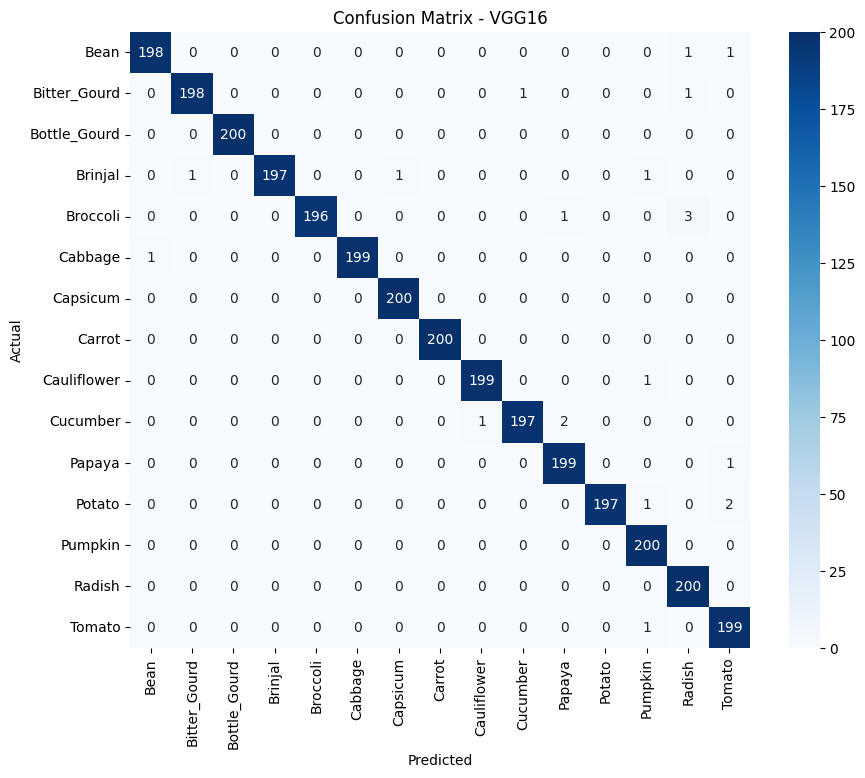

In [26]:
# Evaluasi model VGG16
vgg_metrics = evaluate_model_metrics(vgg_model, test_generator, "VGG16")

94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step
Model: ResNet50
              precision  recall  f1-score   support
Bean              1.000   1.000    1.0000   200.000
Bitter_Gourd      0.995   0.995    0.9950   200.000
Bottle_Gourd      1.000   1.000    1.0000   200.000
Brinjal           1.000   0.990    0.9950   200.000
Broccoli          1.000   1.000    1.0000   200.000
Cabbage           1.000   1.000    1.0000   200.000
Capsicum          1.000   1.000    1.0000   200.000
Carrot            1.000   1.000    1.0000   200.000
Cauliflower       1.000   1.000    1.0000   200.000
Cucumber          0.995   1.000    0.9975   200.000
Papaya            0.995   1.000    0.9975   200.000
Potato            1.000   1.000    1.0000   200.000
Pumpkin           1.000   1.000    1.0000   200.000
Radish            1.000   1.000    1.0000   200.000
Tomato            1.000   1.000    1.0000   200.000
accuracy          0.999   0.999    0.9990     0.999
macro avg         0.999   0.999    0.9990  3000.000
weight

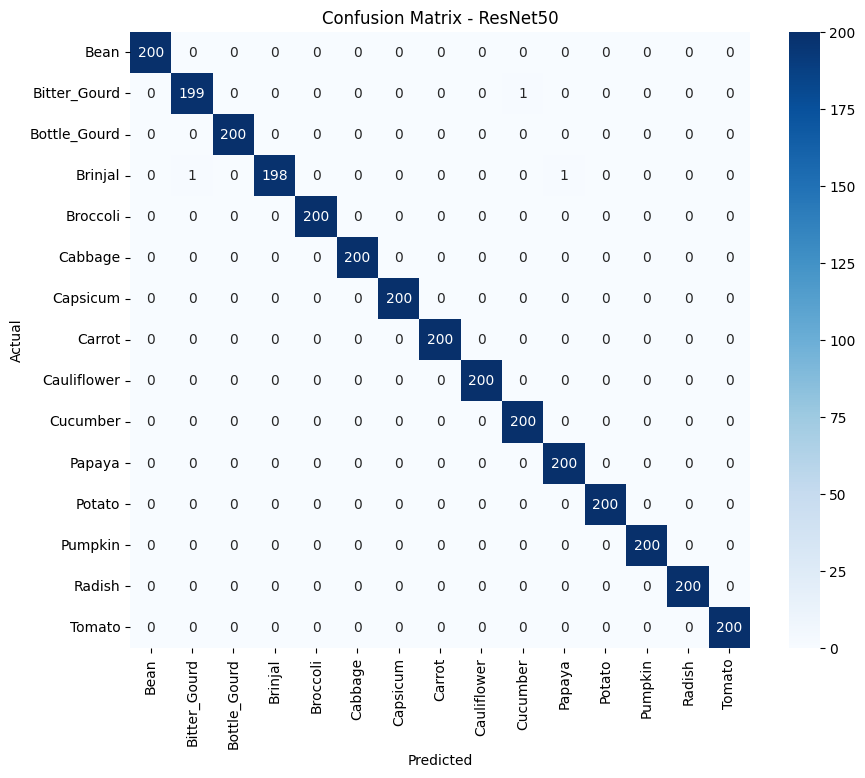

In [32]:
# Evaluasi model ResNet50
resnet_metrics = evaluate_model_metrics(resnet_model, resnet_test_generator, "ResNet50")

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step
Model: MobileNetV2
              precision  recall  f1-score    support
Bean             0.9950  1.0000    0.9975   200.0000
Bitter_Gourd     1.0000  0.9950    0.9975   200.0000
Bottle_Gourd     1.0000  1.0000    1.0000   200.0000
Brinjal          1.0000  1.0000    1.0000   200.0000
Broccoli         0.9950  1.0000    0.9975   200.0000
Cabbage          1.0000  0.9950    0.9975   200.0000
Capsicum         1.0000  1.0000    1.0000   200.0000
Carrot           1.0000  1.0000    1.0000   200.0000
Cauliflower      1.0000  0.9950    0.9975   200.0000
Cucumber         0.9950  1.0000    0.9975   200.0000
Papaya           0.9950  0.9950    0.9950   200.0000
Potato           1.0000  1.0000    1.0000   200.0000
Pumpkin          0.9950  1.0000    0.9975   200.0000
Radish           1.0000  1.0000    1.0000   200.0000
Tomato           1.0000  0.9950    0.9975   200.0000
accuracy         0.9983  0.9983    0.9983     0.9983
macro avg        0.9983  0.9983    0.998

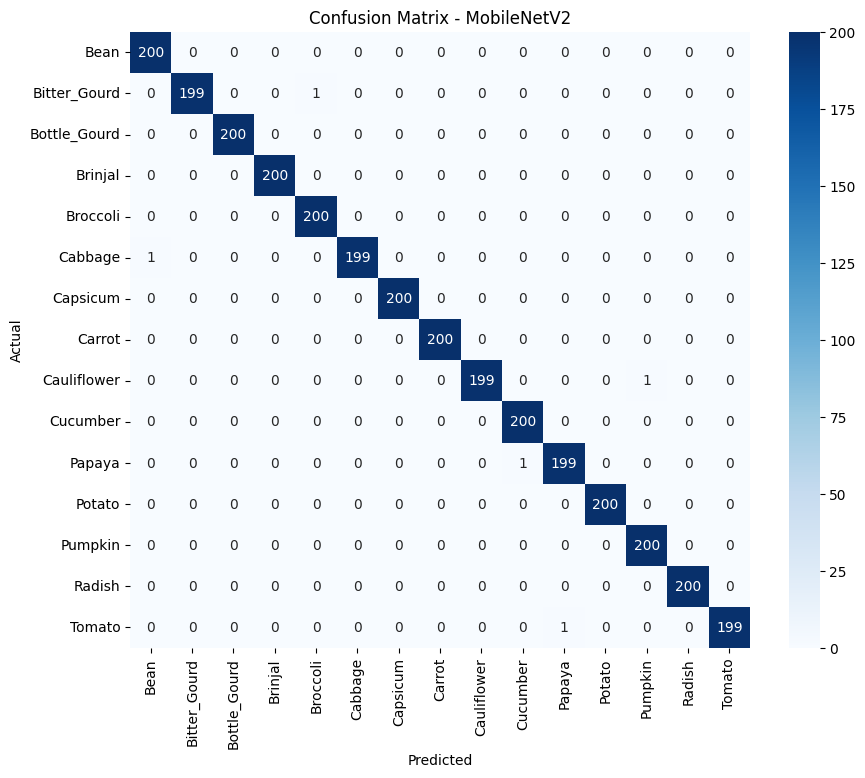

In [28]:
# Evaluasi model MobileNetV2
mobilenet_metrics = evaluate_model_metrics(mobilenet_model, test_generator, "MobileNetV2")

Perbandingan Metrik Semua Model:
         Model  Accuracy  Precision  Recall  F1-Score
0        VGG16    0.9930     0.9931  0.9930    0.9930
1     ResNet50    0.9990     0.9990  0.9990    0.9990
2  MobileNetV2    0.9983     0.9983  0.9983    0.9983


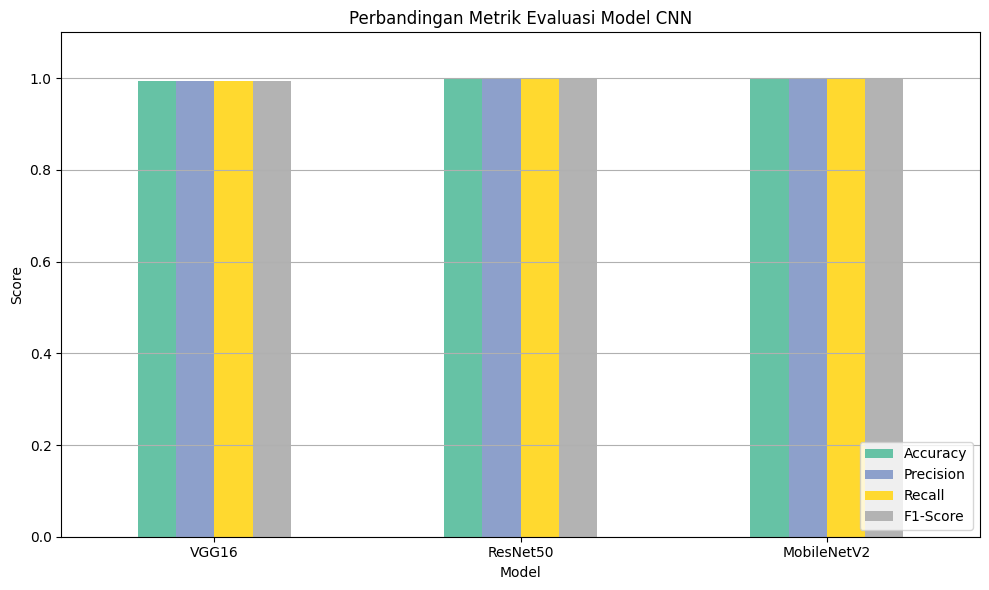

In [33]:
# Gabungkan metrik ke DataFrame
all_metrics_df = pd.DataFrame([vgg_metrics, resnet_metrics, mobilenet_metrics])
all_metrics_df = all_metrics_df.round(4)

# Tampilkan tabel perbandingan
print("Perbandingan Metrik Semua Model:")
print(all_metrics_df)

# Visualisasi Perbandingan
all_metrics_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(
    kind='bar', figsize=(10, 6), colormap='Set2'
)
plt.title("Perbandingan Metrik Evaluasi Model CNN")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


##**7. Visualization**

In [38]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 2)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


### **7.1 VGG16**

ValueError: x and y must have same first dimension, but have shapes (13,) and (12,)

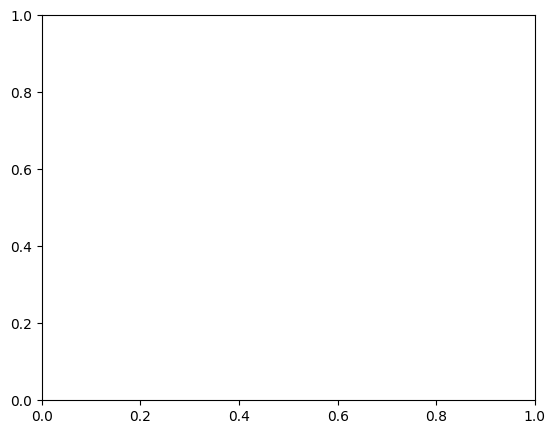

In [36]:
plot_training_history(vgg_history, 'VGG16')

### **7.2 ResNet50**

In [ ]:
plot_training_history(resnet_history, 'ResNet50')

### **7.3 MobileNetV2**

ValueError: x and y must have same first dimension, but have shapes (15,) and (14,)

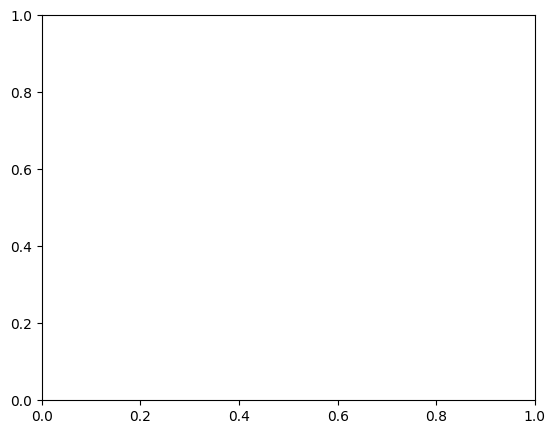

In [37]:
plot_training_history(mobilenet_history, 'MobileNetV2')